In [ ]:
#!pip install mlxtend  
#! pip install --index-url https://test.pypi.org/simple/ PyARMViz

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from collections import Counter
import datetime as dt
import seaborn as sns
# market basket analysis and visualisation
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
sns.set()


# Import 2019 data

In [2]:
df=pd.read_csv('2019.csv')

In [3]:
df = df[['Family','week','store']]

In [4]:
df['week'] = pd.to_datetime(df['week'])

In [5]:
df

,Family,week,store
0,21,2019-01-01,69
1,21,2019-01-01,52
2,21,2019-01-01,209
3,21,2019-01-01,74
4,21,2019-01-01,51
...,...,...,...
20972572,21,2019-11-01,314
20972573,21,2019-11-01,393
20972574,21,2019-11-01,62
20972575,21,2019-11-01,209


In [6]:
# Check family product sells
df['Family'].value_counts()


12    4497827
9     4419158
1     3502871
21    3002867
2     1080691
15    1063874
18     704272
14     583537
8      443970
3      337852
16     285012
6      231206
10     217140
5      119162
13     112072
7      105380
11      88236
19      69209
20      39156
17      39010
4       30075
Name: Family, dtype: int64

In [7]:
df['month'] = df['week'].dt.month

In [8]:
df['order_id'] = df['store'].astype(str)+'.'+df['week'].astype(str) #create order ids

In [9]:
df

,Family,week,store,month,order_id
0,21,2019-01-01,69,1,69.2019-01-01
1,21,2019-01-01,52,1,52.2019-01-01
2,21,2019-01-01,209,1,209.2019-01-01
3,21,2019-01-01,74,1,74.2019-01-01
4,21,2019-01-01,51,1,51.2019-01-01
...,...,...,...,...,...
20972572,21,2019-11-01,314,11,314.2019-11-01
20972573,21,2019-11-01,393,11,393.2019-11-01
20972574,21,2019-11-01,62,11,62.2019-11-01
20972575,21,2019-11-01,209,11,209.2019-11-01


# Dividing the dataset by quarters

In [33]:
first_quarter = df.loc[(df['month']==1) | (df['month']== 2) | (df['month']== 3)| (df['month']== 4)]

In [11]:
second_quarter = df.loc[(df['month']==5) | (df['month']== 6) | (df['month']== 7)| (df['month']== 8)]

In [12]:
third_quarter = df.loc[(df['month']==9) | (df['month']== 10) | (df['month']== 11)| (df['month']== 12)]

In [34]:
first_quarter =first_quarter[['order_id','Family','store']] 

In [35]:
first_quarter

,order_id,Family,store
0,69.2019-01-01,21,69
1,52.2019-01-01,21,52
2,209.2019-01-01,21,209
3,74.2019-01-01,21,74
4,51.2019-01-01,21,51
...,...,...,...
8367362,145.2019-04-30,21,145
8367363,171.2019-04-30,21,171
8367364,184.2019-04-30,21,184
8367365,44.2019-04-30,21,44


In [15]:
second_quarter =second_quarter[['order_id','Family','store']] 

In [16]:
third_quarter =third_quarter[['order_id','Family','store']] 

# CO-OCURRENCES function

In [17]:
# INPUTS
#Stores [1-410]
#Quarters ['first_quarter','second_quarter','third_quarter']
#Family [1-21]



def co_occurences(store,quarter,family):
    '''
    given a store, a quarter and a family of products.
    it provides a visualization with the co-occurences between the families of products.
    
    '''
    
    df = quarter[quarter['store'] == store]
    df =df[['order_id','Family']] 
    
    # Pivot the data - lines as orders and products as columns
    pt1 = pd.pivot_table(df, index='order_id', columns='Family',aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
    
    # calculate co-occurrence matrix
    x = np.array(pt1)
    y = np.array(pt1.T)
    co_matrix = np.dot(y,x)
    np.fill_diagonal(co_matrix, 0)
    quarter = pd.DataFrame(co_matrix, columns = pt1.columns, index = pt1.columns)

 
    
    
    
    quarter['Family'] = quarter.index
    ax = sns.barplot(x='Family', y=family, data=quarter,
                 palette="Blues_d")
    ax.set(xlabel='Family', ylabel='Co-ocurrences')
    
    return(quarter[family],ax)


(Family
1       0.0
2     120.0
3     117.0
4      46.0
5     110.0
6     116.0
7     104.0
8     118.0
9     120.0
10    119.0
11    118.0
12    120.0
13    115.0
14    120.0
15    120.0
16    120.0
17     93.0
18    119.0
19     99.0
20    105.0
21    120.0
Name: 1, dtype: float64, <AxesSubplot:xlabel='Family', ylabel='Co-ocurrences'>)


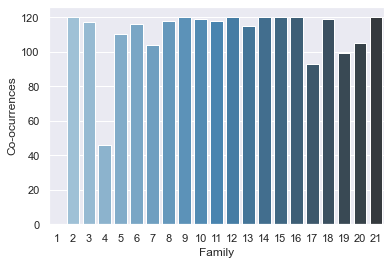

In [18]:
print(co_occurences(292,first_quarter,1))

In [37]:
first_quarter.drop('store',axis=1,inplace=True)

In [39]:
second_quarter.drop('store',axis=1,inplace=True)

In [40]:
third_quarter.drop('store',axis=1,inplace=True)

# Association rules by quarter

In [38]:
# Pivot the data - lines as orders and products as columns
pt1 = pd.pivot_table(first_quarter, index='order_id', columns='Family', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt1.head()

Family,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
order_id,,,,,,,,,,,,,,,,,,,,,
1.2019-01-01,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1.2019-01-02,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1.2019-01-03,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
1.2019-01-04,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1.2019-01-05,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [41]:
# Pivot the data - lines as orders and products as columns
pt2 = pd.pivot_table(second_quarter, index='order_id', columns='Family', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt2.head()

Family,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
order_id,,,,,,,,,,,,,,,,,,,,,
1.2019-05-01,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1.2019-05-02,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
1.2019-05-03,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1.2019-05-04,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1.2019-05-05,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0


In [42]:
# Pivot the data - lines as orders and products as columns
pt3 = pd.pivot_table(third_quarter, index='order_id', columns='Family', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt3.head()

Family,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
order_id,,,,,,,,,,,,,,,,,,,,,
1.2019-09-01,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
1.2019-09-02,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1.2019-09-03,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
1.2019-09-04,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
1.2019-09-05,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0


### Frequent itemsets

In [43]:
frequent_itemsets = apriori(pt1, min_support=0.65, use_colnames=True) #frequent itemsets with >65% support

In [44]:
frequent_itemsets

,support,itemsets
0,0.994997,(1)
1,0.976730,(2)
2,0.896519,(3)
3,0.749922,(5)
4,0.800324,(6)
...,...,...
11417,0.689805,"(2, 3, 8, 9, 12, 13, 14, 15, 16, 18, 21)"
11418,0.669296,"(1, 2, 3, 5, 8, 9, 12, 14, 15, 16, 18, 21)"
11419,0.703029,"(1, 2, 3, 6, 8, 9, 12, 14, 15, 16, 18, 21)"
11420,0.685488,"(1, 2, 3, 8, 9, 10, 12, 14, 15, 16, 18, 21)"


# Association rules for the 1st quarter

In [45]:
# Generate the association rules - by confidence. Finding complementary products with confidence higher than 60%
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
608501,"(2, 3, 8, 13, 14, 16, 21)",(1),0.693210,0.994997,0.693210,1.0,1.005028,0.003468,inf
1656566,"(2, 3, 8, 10, 14, 15, 16, 18, 21)","(1, 9)",0.685508,0.990783,0.685508,1.0,1.009303,0.006318,inf
385642,"(6, 8, 10, 15, 18, 21)",(1),0.651589,0.994997,0.651589,1.0,1.005028,0.003260,inf
385516,"(6, 8, 10, 14, 18, 21)",(1),0.651651,0.994997,0.651651,1.0,1.005028,0.003260,inf
232298,"(8, 10, 16, 18, 21)",(9),0.718016,0.992776,0.718016,1.0,1.007277,0.005187,inf


In [46]:
#the likelihood of buying the products together is way more than the likelihood of buying the products separated
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
round(rulesLift,2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1709182,"(3, 8, 9, 12, 15, 16, 21)","(1, 2, 5, 14, 18)",0.82,0.74,0.67,0.82,1.1,0.06,1.42
1710219,"(1, 2, 5, 14, 18)","(3, 8, 9, 12, 15, 16, 21)",0.74,0.82,0.67,0.90,1.1,0.06,1.88
1710031,"(3, 8, 9, 12, 16, 21)","(1, 2, 5, 14, 15, 18)",0.82,0.74,0.67,0.82,1.1,0.06,1.42
1708777,"(1, 3, 8, 9, 12, 16, 21)","(2, 5, 14, 15, 18)",0.82,0.74,0.67,0.82,1.1,0.06,1.42
1700361,"(3, 8, 9, 12, 16, 21)","(2, 5, 14, 15, 18)",0.82,0.74,0.67,0.82,1.1,0.06,1.42
...,...,...,...,...,...,...,...,...,...
19,(14),(1),0.99,0.99,0.99,1.00,1.0,0.00,1.81
168,(12),(15),0.99,0.99,0.99,0.99,1.0,0.00,1.40
169,(15),(12),0.99,0.99,0.99,1.00,1.0,0.00,1.46
20,(1),(15),0.99,0.99,0.99,0.99,1.0,0.00,1.35


# Association rules for the 2nd quarter

In [47]:
frequent_itemsets2 = apriori(pt2, min_support=0.65, use_colnames=True) #frequent itemsets with >65% support

In [48]:
# Generate the association rules - by confidence. Finding complementary products with confidence higher than 60%
rulesConfidence = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.6)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
111193,"(2, 8, 14, 16, 18)",(12),0.708253,0.995099,0.708253,1.0,1.004925,0.003471,inf
413444,"(2, 8, 10, 14, 15, 18, 21)",(12),0.740841,0.995099,0.740841,1.0,1.004925,0.003631,inf
115843,"(3, 5, 14, 15, 21)",(9),0.698127,0.994268,0.698127,1.0,1.005765,0.004001,inf
316667,"(1, 2, 6, 8, 9, 10, 18)",(12),0.658653,0.995099,0.658653,1.0,1.004925,0.003228,inf
380677,"(2, 3, 5, 8, 14, 18, 21)",(9),0.689053,0.994268,0.689053,1.0,1.005765,0.003949,inf


In [49]:
#the likelihood of buying the products together is way more than the likelihood of buying the products separated
rulesLift = association_rules(frequent_itemsets2, metric="lift", min_threshold=0)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
600801,"(8, 2, 10, 15)","(1, 6, 9, 12, 14, 18, 21)",0.754734,0.783939,0.651038,0.862606,1.100348,0.059372,1.572559
599564,"(1, 6, 9, 12, 14, 18, 21)","(8, 2, 10, 15)",0.783939,0.754734,0.651038,0.830470,1.100348,0.059372,1.446739
600465,"(2, 8, 10, 12, 15)","(1, 6, 9, 14, 18, 21)",0.754714,0.783980,0.651038,0.862629,1.100320,0.059358,1.572530
599900,"(1, 6, 9, 14, 18, 21)","(2, 8, 10, 12, 15)",0.783980,0.754714,0.651038,0.830427,1.100320,0.059358,1.446493
575372,"(8, 2, 10, 15)","(1, 6, 9, 14, 18, 21)",0.754734,0.783980,0.651038,0.862606,1.100291,0.059342,1.572265
574897,"(1, 6, 9, 14, 18, 21)","(8, 2, 10, 15)",0.783980,0.754734,0.651038,0.830427,1.100291,0.059342,1.446373
599898,"(1, 6, 9, 14, 15, 18)","(2, 8, 10, 12, 21)",0.780152,0.758441,0.651038,0.834502,1.100286,0.059339,1.459588
600467,"(2, 8, 10, 12, 21)","(1, 6, 9, 14, 15, 18)",0.758441,0.780152,0.651038,0.858390,1.100286,0.059339,1.552493
600803,"(8, 2, 10, 21)","(1, 6, 9, 12, 14, 15, 18)",0.758481,0.780111,0.651038,0.858344,1.100284,0.059338,1.552277
599562,"(1, 6, 9, 12, 14, 15, 18)","(8, 2, 10, 21)",0.780111,0.758481,0.651038,0.834545,1.100284,0.059338,1.459725


# Association rules for the 3rd quarter

In [50]:
frequent_itemsets3 = apriori(pt3, min_support=0.65, use_colnames=True) #frequent itemsets with >65% support

In [51]:
# Generate the association rules - by confidence. Finding complementary products with confidence higher than 60%
rulesConfidence = association_rules(frequent_itemsets3, metric="confidence", min_threshold=0.6)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
95189,"(6, 8, 9, 16, 21)",(1),0.677285,0.995260,0.677285,1.0,1.004762,0.003210,inf
245110,"(1, 3, 10, 12, 14, 18)",(9),0.741032,0.993854,0.741032,1.0,1.006184,0.004554,inf
204162,"(2, 6, 10, 12, 15, 18)",(1),0.666399,0.995260,0.666399,1.0,1.004762,0.003159,inf
606029,"(1, 2, 3, 6, 8, 15, 16, 18)",(9),0.656517,0.993854,0.656517,1.0,1.006184,0.004035,inf
606034,"(2, 3, 6, 8, 9, 15, 16, 18)",(1),0.656517,0.995260,0.656517,1.0,1.004762,0.003112,inf


In [52]:
#the likelihood of buying the products together is way more than the likelihood of buying the products separated
rulesLift = association_rules(frequent_itemsets3, metric="lift", min_threshold=0)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
927456,"(1, 3, 8, 9, 16, 21)","(2, 6, 12, 14, 15, 18)",0.753926,0.793975,0.655513,0.869466,1.095080,0.056915,1.578322
927821,"(2, 6, 12, 14, 15, 18)","(1, 3, 8, 9, 16, 21)",0.793975,0.753926,0.655513,0.825610,1.095080,0.056915,1.411050
927009,"(2, 6, 9, 12, 14, 15, 18)","(1, 3, 8, 16, 21)",0.793894,0.754007,0.655513,0.825693,1.095074,0.056911,1.411265
928268,"(1, 3, 8, 16, 21)","(2, 6, 9, 12, 14, 15, 18)",0.754007,0.793894,0.655513,0.869373,1.095074,0.056911,1.577818
928252,"(1, 3, 8, 9, 16)","(2, 6, 12, 14, 15, 18, 21)",0.754891,0.792970,0.655513,0.868355,1.095066,0.056907,1.572638
927025,"(2, 6, 12, 14, 15, 18, 21)","(1, 3, 8, 9, 16)",0.792970,0.754891,0.655513,0.826655,1.095066,0.056907,1.413999
928950,"(8, 1, 3, 16)","(2, 6, 9, 12, 14, 15, 18, 21)",0.754971,0.792890,0.655513,0.868263,1.095061,0.056904,1.572145
926327,"(2, 6, 9, 12, 14, 15, 18, 21)","(8, 1, 3, 16)",0.792890,0.754971,0.655513,0.826739,1.095061,0.056904,1.414219
928562,"(2, 6, 14, 15, 18)","(1, 3, 8, 9, 12, 16, 21)",0.794055,0.753886,0.655513,0.825526,1.095027,0.056886,1.410605
926715,"(1, 3, 8, 9, 12, 16, 21)","(2, 6, 14, 15, 18)",0.753886,0.794055,0.655513,0.869512,1.095027,0.056886,1.578267
